## Gridworld City

Gridworld city, a thriving metropolis with a booming technology industry, has recently experienced an influx of grid-loving software engineers. Unfortunately, the city's street parking system, which chares a fixed rate, is struggling to keep up with the increased demand, To Address this, the city council has decided to modify the pricing scheme to better promote social welfare higher when more parking is being used. , the exception being that the city prefers that at least one spot is left unoccupied (so that it is available in case someone really needs it). The city council has created a Markov decision process (MDP) to model the demand for parking with a reward function that reflects its preferences. Now the city has hired you - an expert in dynamic programming to help determine an optimal policy

In [5]:
%%capture
%matplotlib inline
import numpy as np
import pickle
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
import time
import json
from copy import deepcopy

In [6]:
plt.rc('font', size=30)  # controls default text sizes
plt.rc('axes', titlesize=25)  # fontsize of the axes title
plt.rc('axes', labelsize=25)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=17)  # fontsize of the tick labels
plt.rc('ytick', labelsize=17)  # fontsize of the tick labels
plt.rc('legend', fontsize=20)  # legend fontsize
plt.rc('figure', titlesize=30)
plt.tight_layout()


<Figure size 640x480 with 0 Axes>

In [29]:
def plot(V, pi):
    # plot value
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))
    ax1.axis('on')
    ax1.cla()
    states = np.arange(V.shape[0])
    ax1.bar(states, V, edgecolor='none')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Value', rotation='horizontal', ha='right')
    ax1.set_title('Value Function')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax1.yaxis.grid()
    ax1.set_ylim(bottom=V.min())
    # plot policy
    ax2.axis('on')
    ax2.cla()
    im = ax2.imshow(pi.T, cmap='Greys', vmin=0, vmax=1, aspect='auto')
    ax2.invert_yaxis()
    ax2.set_xlabel('State')
    ax2.set_ylabel('Action', rotation='horizontal', ha='right')
    ax2.set_title('Policy')
    start, end = ax2.get_xlim()
    ax2.xaxis.set_ticks(np.arange(start, end), minor=True)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    start, end = ax2.get_ylim()
    ax2.yaxis.set_ticks(np.arange(start, end), minor=True)
    ax2.grid(which='minor')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.20)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('Probability', rotation=0, ha='left')
    fig.subplots_adjust(wspace=0.5)
    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(0.001)
    plt.close()

In [30]:
class ParkingWorld:
    def __init__(self,
                num_spaces=10,
                num_prices=4,
                price_factor=0.1,
                occupants_factor=1.0,
                null_factor=1 / 3):
        self.__num_spaces = num_spaces
        self.__num_prices = num_prices
        self.__occupants_factor = occupants_factor
        self.__price_factor = price_factor
        self.__null_factor = null_factor
        self.__S = [num_occupied for num_occupied in range(num_spaces + 1)]
        self.__A = list(range(num_prices))

    def transitions(self, s, a):
        return np.array([[r, self.p(s_, r, s, a)] for s_, r in self.support(s, a)])
    
    def support(self, s, a):
        return [(s_, self.reward(s, s_)) for s_ in self.__S]
    
    def reward(self, s, s_):
        return self.state_reward(s) + self.state_reward(s_)
    
    def state_reward(self, s):
        if s == self.__num_spaces:
            return self.__null_factor * s * self.__occupants_factor
        else: 
            return s * self.__occupants_factor
    
    def random_state(self):
        return np.random.randint(self.__num_prices)
    
    def step(self, s, a):
        probabilities = [
            self.p(s_, self.reward(s, s_), s, a) for s_ in self.__S
        ]
        return np.random.choice(self.__S, p=probabilities)
    
    def p(self, s_, r, s, a):
        if r!= self.reward(s, s_):
            return 0
        else:
            center = ( 1 - self.__price_factor
                      ) * s + self.__price_factor * self.__num_spaces * (
                          1 - a / self.__num_prices)
            emphasis = np.exp(
                -abs(np.arange(2 * self.__num_spaces) - center) / 5)
            if s_ == self.__num_spaces:
                return sum(emphasis[s_:]) / sum(emphasis)
            return emphasis[s_] / sum(emphasis)
    @property
    def A(self):
        return list(self.__A)

    @property
    def num_spaces(self):
        return self.__num_spaces

    @property
    def num_prices(self):
        return self.num_prices

    @property
    def S(self):
        return list(self.__S)
 


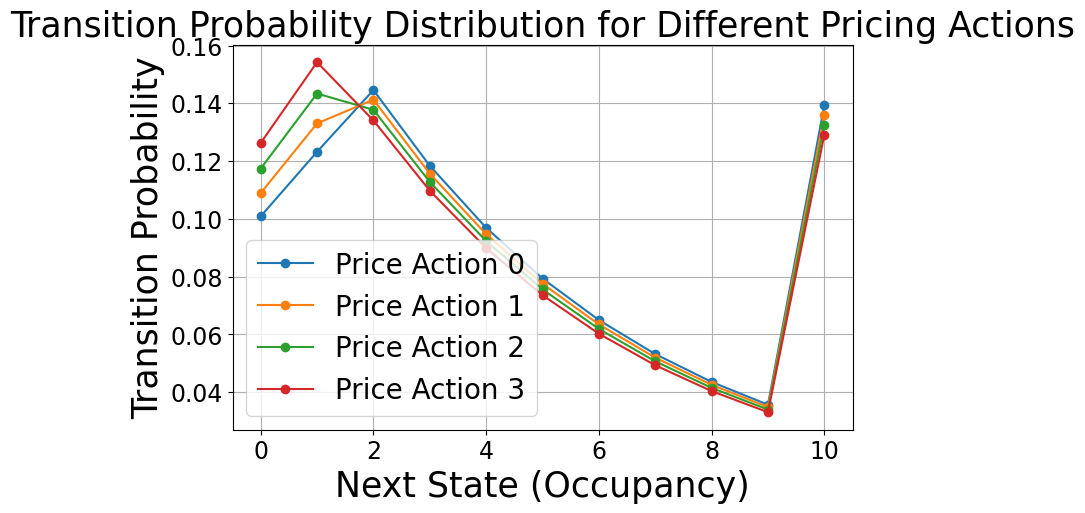

In [21]:
import numpy as np 
import matplotlib.pyplot as plt 

world = ParkingWorld()
current_state = 1 # Play with the current state and observe the probability distribution change
plt.figure(figsize=(8,5))

for a in world.A:
    probabilities = []
    for next_state in world.S:
        r = world.reward(current_state, next_state)
        prob = world.p(next_state, r, current_state, a)
        probabilities.append(prob)

    # Plot the distribution for this pricing action
    plt.plot(world.S, probabilities, marker='o', label=f"Price Action {a}")

plt.xlabel("Next State (Occupancy)")
plt.ylabel("Transition Probability")
plt.title("Transition Probability Distribution for Different Pricing Actions")
plt.legend()
plt.grid(True)
plt.show()


## World Analysis
- **Purpose:**  
  The class models a parking environment as a Markov Decision Process (MDP). In this world, states represent the number of occupied parking spaces (ranging from 0 to a maximum, defined by `num_spaces`), and actions represent pricing decisions (indexed from 0 to `num_prices - 1`).

- **Key Parameters:**  
  - **num_spaces:** Maximum number of parking spaces.  
  - **num_prices:** Number of different pricing options available.  
  - **price_factor:** Determines how much the price affects the transition dynamics.  
  - **occupants_factor:** A multiplier for rewards based on occupancy.  
  - **null_factor:** A modifier applied when the parking lot is full (i.e., when the state equals `num_spaces`).

---

### Initialization

- **States and Actions:**  
  - **States (`self.__S`):** A list of possible occupancy values from 0 to `num_spaces` (inclusive).  
  - **Actions (`self.__A`):** A list of pricing indices from 0 to `num_prices - 1`.

- **Notes:**  
  The initialization sets up the environment but assumes that external code has imported NumPy (referenced as `np`).

---

### Methods Analysis

1. **`transitions(self, s, a)`**  
   - **Goal:** Returns a NumPy array of pairs `[r, probability]` for each potential next state.  
   - **Mechanism:** It iterates over the output of `support(s, a)` and computes transition probabilities using `p(s_, r, s, a)`.

2. **`support(self, s, a)`**  
   - **Goal:** Intended to generate a list of tuples with each tuple containing a possible next state and the corresponding reward when transitioning from state `s`.  
   - **Issue:**  
     The syntax is off:
     ```python
     return [(s_, self.reward(s,s_) for s_ in self.__S)]
     ```
     It appears the intended code was a list comprehension:
     ```python
     return [(s_, self.reward(s, s_)) for s_ in self.__S]
     ```
     As written, it creates a tuple with a generator expression, which will lead to errors.

3. **`reward(self, s, s_)` & `state_reward(self, s)`**  
   - **Reward Calculation:**  
     - The reward for a transition is defined as the sum of the "state rewards" of the current state and the next state.  
     - For any state `s`, the reward is usually `s * occupants_factor`.  
     - However, if the state is the maximum (i.e., the parking lot is full), it is scaled by the `null_factor` (i.e., `null_factor * s * occupants_factor`).

4. **`p(self, s_, r, s, a)`**  
   - **Purpose:** Computes the probability of transitioning to state `s_` given the current state `s`, action `a`, and an expected reward `r`.  
   - **How It Works:**  
     - **Reward Check:** Returns 0 if the provided reward `r` doesn’t match the computed reward for moving to `s_`.  
     - **Center Calculation:** Computes a “center” value that is a weighted average between the current occupancy `s` and a term that depends on the pricing action.  
     - **Exponential Emphasis:** Uses an exponential decay function centered on this computed value to create a probability distribution.  
     - **Boundary Condition:** If `s_` is the maximum state (parking full), it aggregates the tail of the emphasis vector.

5. **`step(self, s, a)`**  
   - **Intention:** To sample the next state based on the computed probabilities over all possible states.  
   - **Issue:**  
     Similar to `support`, the code snippet:
     ```python
     probabilities = [
         self.p(s_, self.reward(s, s_) for s_ in self.__S)
     ]
     ```
     is not correctly using a list comprehension. It likely should be:
     ```python
     probabilities = [self.p(s_, self.reward(s, s_), s, a) for s_ in self.__S]
     ```
     so that each state's probability is computed correctly.

6. **`random_state(self)`**  
   - **Observation:**  
     This method returns a random integer from `0` to `num_prices - 1`:
     ```python
     return np.random.randint(self.__num_prices)
     ```
   - **Potential Bug:**  
     Given that states are defined as occupancy levels from `0` to `num_spaces`, this method probably should return a random state (i.e., between `0` and `num_spaces`) rather than a random price index.

---

### Properties

- **`A` and `S`:**  
  These properties correctly return copies of the internal action and state lists.

- **`num_spaces`:**  
  Returns the total number of spaces (read-only).

- **`num_prices`:**  
  **Bug:**  
  The property is defined as:
  ```python
  @property
  def num_prices(self):
      return self.num_prices
  ```
  This causes infinite recursion since it refers to itself rather than the private variable. The intended code is likely:
  ```python
  @property
  def num_prices(self):
      return self.__num_prices
  ```

---

### Summary

The class is intended to simulate a parking environment where pricing affects the probability distribution of occupancy changes. While the underlying idea is coherent—using parameters to influence rewards and transitions—the implementation has several syntactical and logical errors that need correction. Addressing these issues (especially the list comprehensions and property definitions) is essential for the class to function as intended.

Let me know if you need help correcting any part of the code or further details on the analysis!

### Why The Choice of Center in The Probability Distribution?

The "center" in the probability function is computed as follows:

```python
center = (1 - self.__price_factor) * s + self.__price_factor * self.__num_spaces * (1 - a / self.__num_prices)
```

**Interpretation:**

- **Current Occupancy Influence:**  
  The term `(1 - self.__price_factor) * s` means that the current state (the number of occupied spaces) carries a significant weight. If the parking lot is moderately full, the next state is likely to be near this current level.

- **Pricing Impact:**  
  The second term, `self.__price_factor * self.__num_spaces * (1 - a / self.__num_prices)`, introduces the pricing decision into the dynamics:
  - **Low Price (small `a`):**  
    When you set a low price, `(1 - a / self.__num_prices)` is closer to 1, so the second term becomes larger. This pushes the center toward a higher occupancy (closer to the maximum number of spaces). Essentially, low prices are expected to attract more drivers.
  - **High Price (large `a`):**  
    Conversely, a high price reduces this term, meaning the center stays closer to the current occupancy. High prices are expected to deter new customers, so you wouldn’t see a big jump in occupancy.

The weighted average thus balances the current occupancy with an expectation based on the pricing policy, creating a smooth transition in probabilities.

---

1. **Using \(exp(-abs(x - center\)\)**:  
   This yields a symmetric “peak” around the center.

2. **“Tail” Aggregation at Full Capacity**:  
   Anything that would push the occupancy above the total number of spaces gets folded back into that maximum state, creating the spike you see at the far right of the graph.

When the current state is very low (like 1), you see a similar effect but in reverse near zero. If the center drifts below zero, you’d get some “tail” probability that can’t go below zero. That portion would effectively get pinned at state 0—though in this particular code, it’s only explicitly handling the case for the maximum state. Because the exponential range is from 0 to \(2 \times \text{num_spaces}\), the lower bound isn’t forced into 0 quite as explicitly, but you’d still see minimal probability assigned to negative occupancy.

So in summary:

- **Symmetry**: The absolute value in the exponent gives a symmetric shape around the center.  
- **Boundary Effects**: Because occupancy cannot exceed the physical capacity (or go below 0), the “tail” gets aggregated at the boundary. That’s why the distribution spikes at the max occupancy (and would similarly spike at 0 if you tried to push below zero).

This behavior can be realistic in certain settings—e.g., if you’re nearly at capacity, any “overflow” is forced to remain at capacity. But if you want more nuanced boundary behavior, you might switch to a different approach (e.g., a truncated distribution that re-normalizes at both ends). For your use case, it sounds like the current method provides the shape you want while still handling the physical constraints of the parking lot.

## Preliminaries

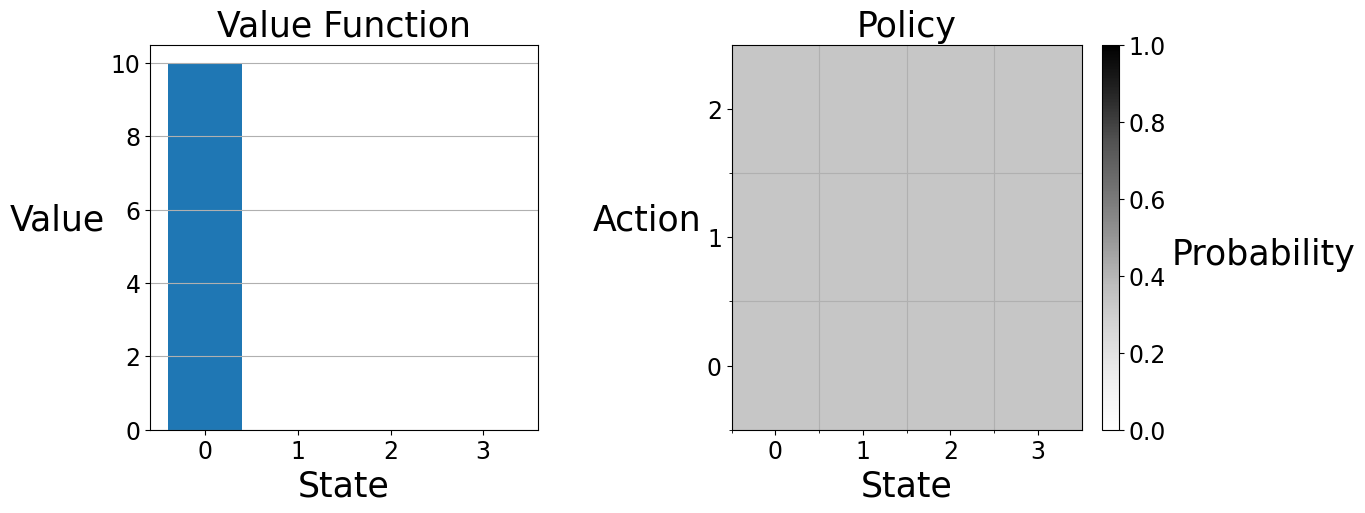

In [31]:
num_spaces = 3 
num_prices = 3
env = ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
state = 0
value = 10
V[state] = value
pi = np.ones((num_spaces + 1, num_prices)) / num_prices
for s, pi_s in enumerate(pi):
    print(f''.join(f'pi(A={a}|S={s} = {p.round(2)})' + 4 * ' ' for a, p in enumerate(pi_s)))
plot(V,pi)



## Policy Evaluation
The city council would like you to evaluate the quality of the existing pricing scheme. Policy evaluation works by iteratively applying the Bellman equation for $v_{\pi}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$

In [68]:
def bellman_update(env, V, pi, s, gamma):
    '''Mutate `V` according to the Bellman update equation'''
    v = 0 
    for action in env.A:
        action_prob = pi[s][action]
        transitions = env.transitions(s, action)
        for next_state in env.S:
            reward = transitions[next_state, 0]
            prob = transitions[next_state, 1]
            v += action_prob * prob * (reward + gamma * V[next_state])
    V[s] = v
        
def evaluate_policy(env, V, pi, gamma, theta):
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

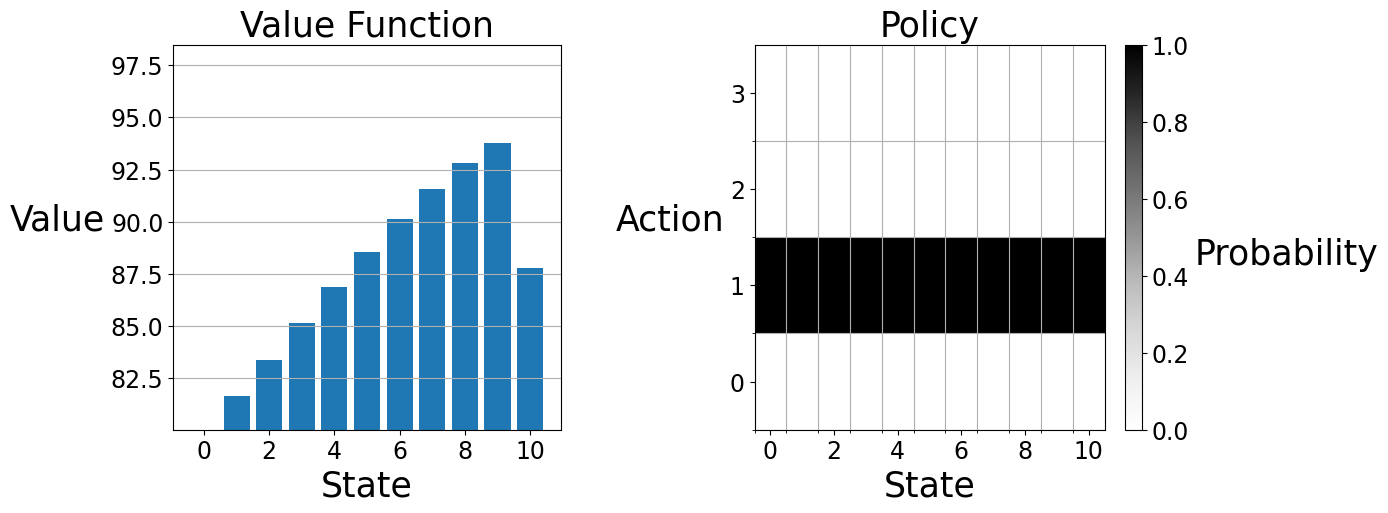

In [69]:
num_spaces = 10
num_prices = 4
env = ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1
gamma = 0.9 
theta = 0.1
V = evaluate_policy(env, V, city_policy, gamma, theta)
plot(V, city_policy)

Observe that the value function qualitatively resembles the city council's preferences &mdash; it monotonically increases as more parking is used, until there is no parking left, in which case the value is lower. Because of the relatively simple reward function (more reward is accrued when many but not all parking spots are taken and less reward is accrued when few or all parking spots are taken) and the highly stochastic dynamics function (each state has positive probability of being reached each time step) the value functions of most policies will qualitatively resemble this graph. However, depending on the intelligence of the policy, the scale of the graph will differ. In other words, better policies will increase the expected return at every state rather than changing the relative desirability of the states. Intuitively, the value of a less desirable state can be increased by making it less likely to remain in a less desirable state. Similarly, the value of a more desirable state can be increased by making it more likely to remain in a more desirable state. That is to say, good policies are policies that spend more time in desirable states and less time in undesirable states. As we will see in this assignment, such a steady state distribution is achieved by setting the price to be low in low occupancy states (so that the occupancy will increase) and setting the price high when occupancy is high (so that full occupancy will be avoided).

## Policy Iteration

Now the city council would like us to compute a more efficient policy using policy iteration. Policy iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function. 

In [70]:
def q_greedify_policy(env, V, pi, s, gamma):
    """Mutate `pi` to be greedy with respect to the q-values induced by `v`"""
    A = np.zeros(len(env.A))
    for action in env.A:
        transitions = env.transitions(s, action)
        for next_state in env.S:
            reward = transitions[next_state,0]
            prob = transitions[next_state,1]
            A[action] += prob * (reward + gamma * V[next_state])
    best_action = np.argmax(A)
    pi[s] = np.eye(len(env.A))[best_action]

def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old):
            policy_stable = False
    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S),len(env.A))) / len(env.A)
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
    return V, pi     

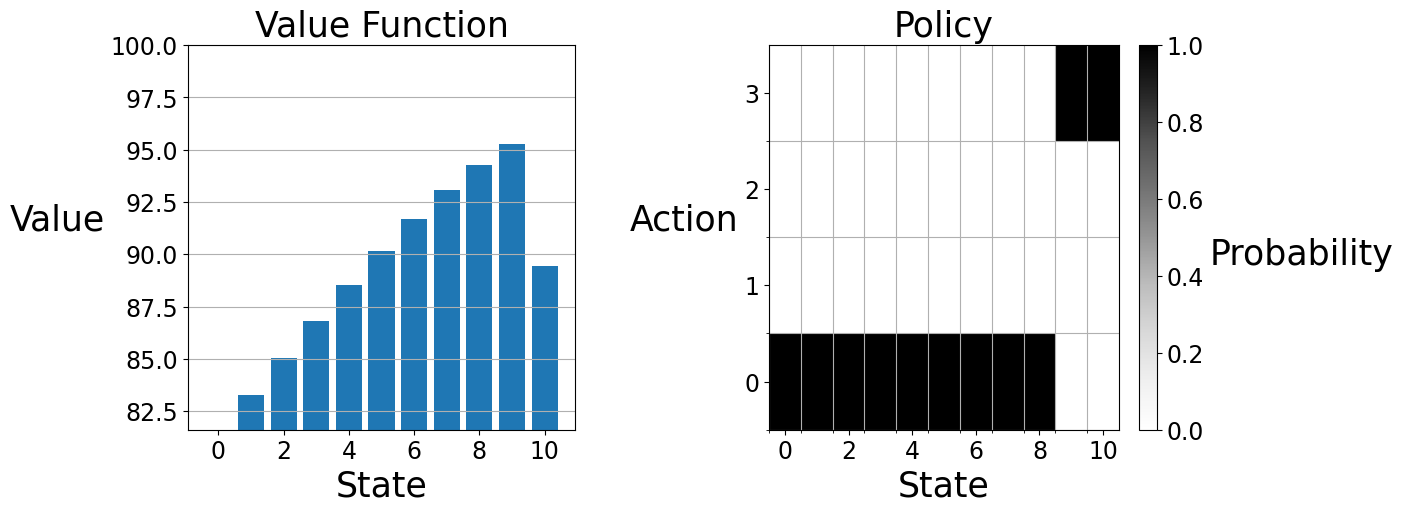

In [72]:
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)
plot(V, pi)


## Value Iteration

The city has also heard about value iteration and would like you to implement it. Value iteration works by iteratively applying the Bellman optimality equation for $v_{\ast}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$


In [87]:

def bellman_optimality_update(env, v, s, gamma):
    """Mutate `V` according to the bellman optimality update equation"""
    v = np.zeros(len(env.A))
    for action in env.A:
        transitions = env.transitions(s, action)
        for next_state in env.S:
            reward = transitions[next_state, 0]
            prob = transitions[next_state, 1]
            v[action] += prob * (reward + gamma * V[next_state])
    V[s] = np.max(v)
    return V      

def value_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    while True:
        delta = 0 
        for s in env.S:
            v = V[s]
            V = bellman_optimality_update(env, V, s, gamma)
            delta= max(delta, abs(v - V[s]))
        if delta < theta:
            break
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

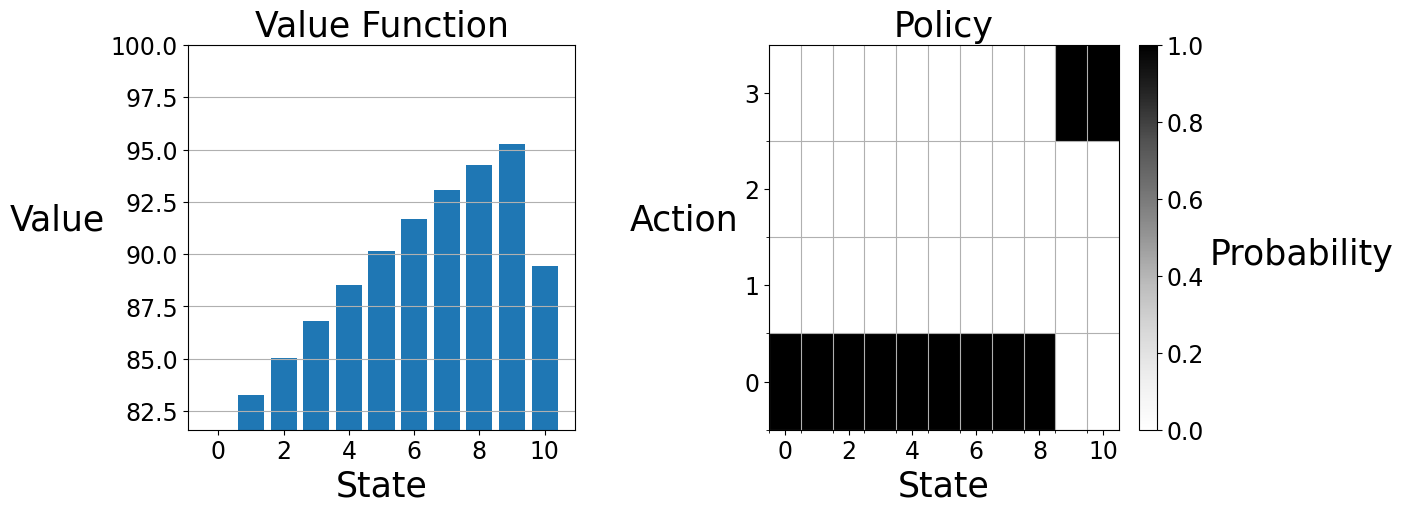

In [88]:
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)
plot(V, pi)

In the value iteration algorithm above, a policy is not explicitly maintained until the value function has converged. Below, we have written an identically behaving value iteration algorithm that maintains an updated policy. Writing value iteration in this form makes its relationship to policy iteration more evident. Policy iteration alternates between doing complete greedifications and complete evaluations. On the other hand, value iteration alternates between doing local greedifications and local evaluations. 

In [89]:
def value_iteration2(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    while True:
        delta = 0 
        for s in env.S:
            v = V[s]
            q_greedify_policy(env, V, pi, s, gamma)
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V, pi

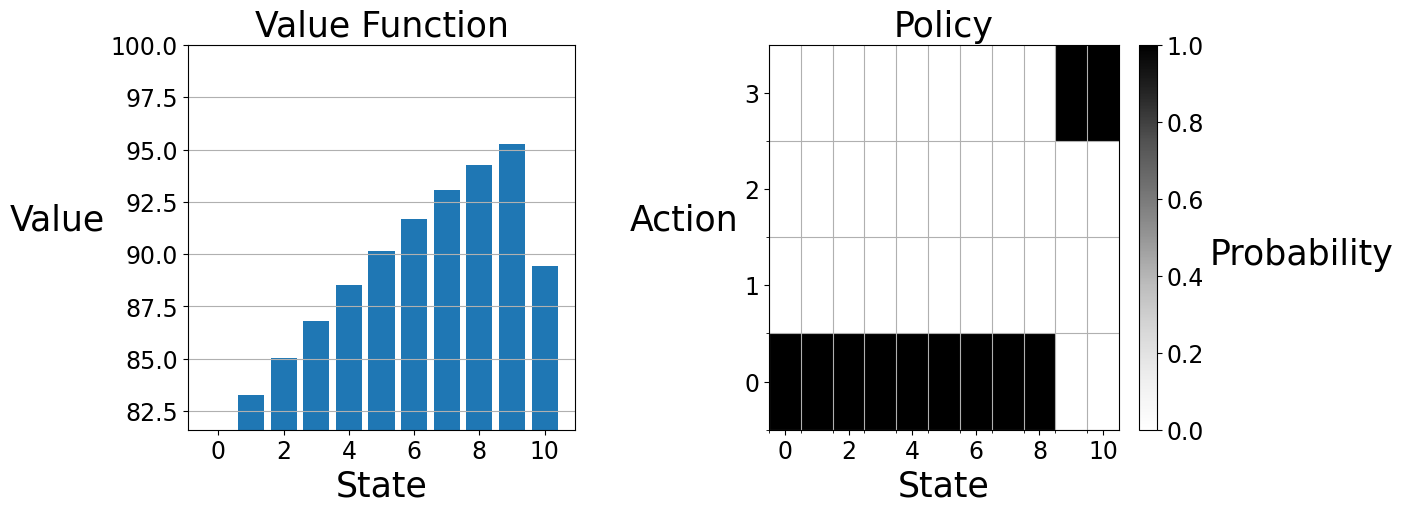

In [90]:
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
plot(V, pi)

## Asynchronous Programming
So far in this assignment we've been working with synchronous algorithms, which update states in systematic sweeps. In contrast, asynchronous algorithms are free to update states in any order. Asynchronous algorithms can offer significant advantages in large MDPs, where even one synchronous sweep over the state space may be prohibitively expensive. One important type of asynchronous value iteration is known as real-time dynamic programming. Like sychronous value iteration, real-time dynamic programming updates a state by doing a local greedification followed by a local evaluation; unlike synchronous value iteration, real-time dynamic programming determines which state to update using the stream of experience generated by its policy. An outline of the algorithm is written below. Complete it by filling in the helper function. Remember that you are free to reuse functions that you have already written!

In [96]:
def real_time_dynamic_programming_helper(env, V, pi, s, gamma):
    """Mutate ``pi`` and ``V`` appropriately."""
    q_greedify_policy(env, V, pi, s, gamma)
    V = bellman_optimality_update(env, V, s, gamma)
    return V

def real_time_dynamic_programming(env, gamma, horizon):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    s = env.random_state()
    for t in range(horizon):
        V =real_time_dynamic_programming_helper(env, V, pi, s, gamma)
        a = np.random.choice(env.A, p=pi[s])
        s = env.step(s, a)
    return V, pi

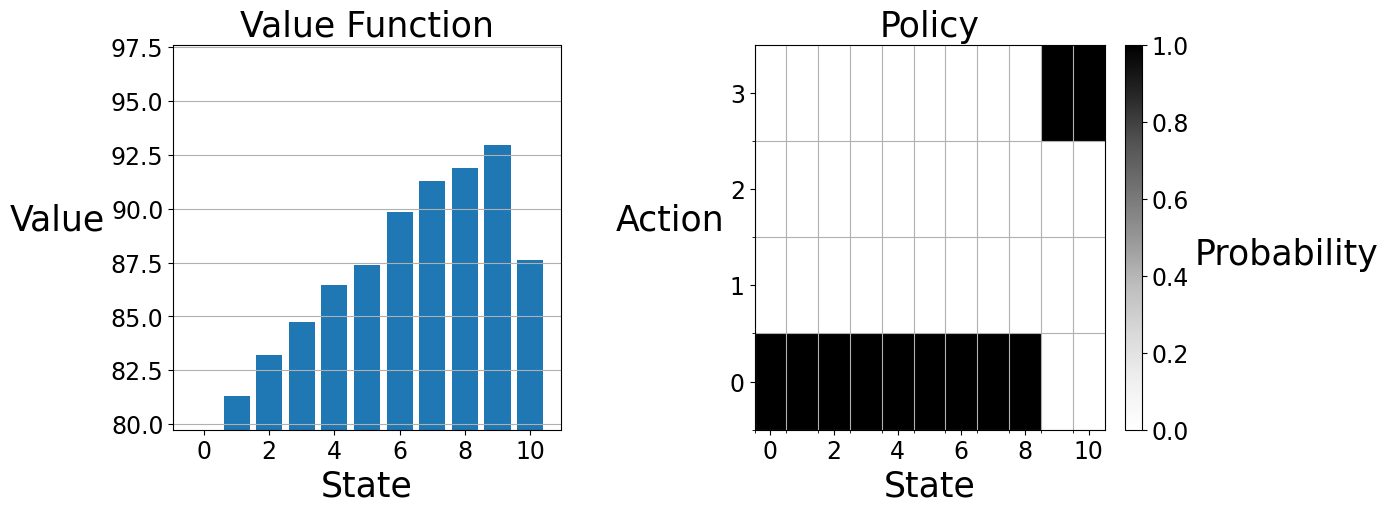

In [97]:
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
horizon = 500
np.random.seed(101)
V, pi = real_time_dynamic_programming(env, gamma, horizon)
plot(V, pi)

Notice that these values differ from those of the synchronous methods we ran to convergence, indicating that the real-time dynamic programming algorithm needs more than 500 steps to converge. One takeaway from this result is that, while asychronous methods scale better to larger MDPs, they are not always the right choice — in small MDPs in which all states are visited frequently, such as the Gridworld City parking MDP, synchronous methods may offer better performance.

The cell below will check that your code passes the test case above. (Your code passed if the cell runs without error.) Your solution will also be checked against hidden test cases for your final grade. (So don't hard code parameters into your solution.)
